In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split

from glob import glob
from skimage.io import imread
from os import listdir
import seaborn as sns
sns.set()

import time
import copy
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
import cv2

In [2]:
base_path = "C:/Users/umroot/Downloads/Dataset_ml/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [3]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

In [4]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
1,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
2,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
3,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
4,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0


In [5]:
print(data['target'].value_counts())

0    198738
1     78786
Name: target, dtype: int64


In [6]:
data.target.unique()

array([0, 1], dtype=object)

In [7]:
data.shape

(277524, 3)

In [8]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [9]:
patients = data.patient_id.unique()

In [10]:
patients = patients[:round(len(patients)*.2)]

In [11]:
len(patients)

56

In [12]:
sub_train_ids, test_ids = train_test_split(patients,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

In [13]:
print(f"Now, we're taking {round(len(train_ids)/patients.shape[0]*100, 1)}% for training, {round(len(valid_ids)/patients.shape[0]*100,1)}% for validation, {round(len(test_ids)/patients.shape[0]*100,1)}% for testing")

Now, we're taking 69.6% for training, 8.9% for validation, 21.4% for testing


In [14]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

39, 5, 12


In [15]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
valid_df = data.loc[data.patient_id.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (47697, 3)
test set shape: (14629, 3)
validation set shape: (7383, 3)


In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
NUM_CLASSES = 2
target_size = (224,224)
batch_size = 32

In [18]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 47697 validated image filenames belonging to 2 classes.
Found 7383 validated image filenames belonging to 2 classes.
Found 14629 validated image filenames belonging to 2 classes.


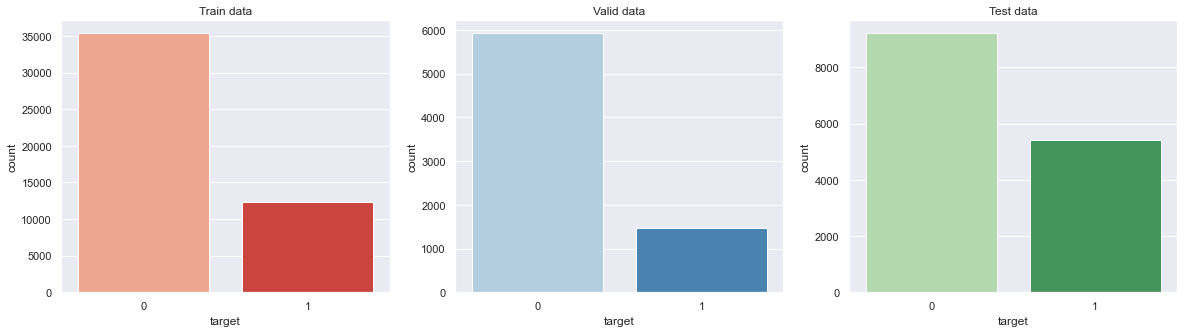

In [19]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
#base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")
#from tensorflow.keras.models import Model

In [49]:
# Freezing Layers
#model = InceptionV3(input_tensor=Input(shape=(224, 224, 3)), include_top=True,weights='imagenet')
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [50]:
for layer in model.layers:
    layer.trainable = False
#model.summary()

In [51]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten()) 
model.add(Dense(1,activation='sigmoid'))

In [52]:

# last_layer = model.get_layer('avg_pool').output
# x= Flatten(name='flatten')(last_layer)
# out = Dense(2, activation='softmax', name='output')(last_layer)
# # custom_inception_model = Model(image_input, out)
# # custom_inception_model.summary()
# model.summary()

In [53]:
# Building Model

# model=Sequential()
# model.add(base_model)
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(1,activation='sigmoid'))

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [55]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.0001), metrics=['accuracy'])

In [56]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint("Breast_Cancer_inceptionv3_model.h5", save_best_only=True, verbose = 0)
callbacks = [
    early_stopping,
    model_checkpoints
]

In [ ]:
inception_history = model.fit(train_batches, validation_data = valid_batches, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
1491/1491 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7546

In [ ]:
model.save("inceptionv3_mode.h5")